# 1. Imports

In [31]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt
import datetime as dt
import os

# 2. Loading the dataset

In [11]:
df = pd.read_csv("../../data/processed/COEN498-691_HAR_dataset.csv", header=0, sep = ",")
df.head(10)

,timestamp,activity_id,participant_id,ax,ay,az
0,1.760380e+09,sitting,ZM,-0.001,0.849,0.484333
1,1.760380e+09,sitting,ZM,-0.008,0.850,0.483000
2,1.760380e+09,sitting,ZM,0.006,0.852,0.480000
3,1.760380e+09,sitting,ZM,0.001,0.851,0.477000
4,1.760380e+09,sitting,ZM,-0.002,0.853,0.481000
5,1.760380e+09,sitting,ZM,0.008,0.841,0.479000
6,1.760380e+09,sitting,ZM,-0.005,0.851,0.484000
7,1.760380e+09,sitting,ZM,-0.002,0.857,0.481000
8,1.760380e+09,sitting,ZM,0.002,0.847,0.478000
9,1.760380e+09,sitting,ZM,-0.004,0.853,0.467000


In [12]:
participant_ids = np.unique(df['participant_id'])
print("Participant IDs:", participant_ids)

Participant IDs: ['LL' 'VV' 'YL' 'YT' 'ZM']


In [13]:
activity_mapper = {
    'sitting': 1,
    'walking': 2,
    'running': 3,
    'lying': 4,
}

In [14]:
mapped_activities = df.activity_id.apply(lambda x: activity_mapper[x])
df.loc[:, 'activity_id'] = mapped_activities
activity_ids = np.unique(df['activity_id'])
print("Activity IDs:", activity_ids)
print(df.head(10))

Activity IDs: [1 2 3 4]
      timestamp activity_id participant_id     ax     ay        az
0  1.760380e+09           1             ZM -0.001  0.849  0.484333
1  1.760380e+09           1             ZM -0.008  0.850  0.483000
2  1.760380e+09           1             ZM  0.006  0.852  0.480000
3  1.760380e+09           1             ZM  0.001  0.851  0.477000
4  1.760380e+09           1             ZM -0.002  0.853  0.481000
5  1.760380e+09           1             ZM  0.008  0.841  0.479000
6  1.760380e+09           1             ZM -0.005  0.851  0.484000
7  1.760380e+09           1             ZM -0.002  0.857  0.481000
8  1.760380e+09           1             ZM  0.002  0.847  0.478000
9  1.760380e+09           1             ZM -0.004  0.853  0.467000


In [27]:
sensor_ids = ['ax', 'ay', 'az']

# 3. Trimming
**Removing Transition Noise at the End of Activity Recording**

In [74]:
sampling_frequency = 25  # Hz
trim_duration = 5  # seconds
trim_samples = int(trim_duration * sampling_frequency)

In [75]:
trimmed_dfs = []

for participant_id in participant_ids:
    participant_data = df[df['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id].copy()
        if len(activity_data) > trim_samples:
            trimmed_activity_data = activity_data.iloc[:-trim_samples]
            trimmed_dfs.append(trimmed_activity_data)
df_trimmed = pd.concat(trimmed_dfs, ignore_index=True)

# 4. Filtering
**Applying Band-Pass Filter (0.5 Hz to 15 Hz)**

In [83]:
sampling_frequency = 50  # Hz
lowcut = 0.5  # Hz
highcut = 15.0  # Hz

In [ ]:
def butterworth_bandpass_filter(dataframe, lowcut, highcut, sampling_frequency, order=4):
    """
    Apply a Butterworth bandpass filter to the specified sensor columns (ax, ay, az) in the dataframe.
    """
    filtered_data = dataframe.copy()
    nyquist = 0.5 * sampling_frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    for sensor_id in sensor_ids:
        if sensor_id in filtered_data.columns:
            filtered_data[sensor_id] = signal.filtfilt(b, a, filtered_data[sensor_id])
    return filtered_data

In [ ]:
# Apply the bandpass filter to each participant-activity pair
filtered_dfs = []

for participant_id in participant_ids:
    participant_data = df_trimmed[df_trimmed['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id].copy()
        if not activity_data.empty:
            filtered_activity_data = butterworth_bandpass_filter(activity_data, lowcut, highcut, sampling_frequency)
            filtered_dfs.append(filtered_activity_data)
filtered_df = pd.concat(filtered_dfs, ignore_index=True)

print(filtered_df.head(10))

      timestamp activity_id participant_id        ax        ay        az
0  1.760381e+09           1             LL  0.002073  0.000974  0.003084
1  1.760381e+09           1             LL -0.016937 -0.003016  0.005075
2  1.760381e+09           1             LL -0.011152 -0.001729  0.006335
3  1.760381e+09           1             LL -0.001185  0.000298  0.005951
4  1.760381e+09           1             LL -0.003607 -0.001046  0.006859
5  1.760381e+09           1             LL -0.004682 -0.001573  0.010832
6  1.760381e+09           1             LL -0.000021  0.000150  0.013601
7  1.760381e+09           1             LL  0.000438 -0.000336  0.011900
8  1.760381e+09           1             LL -0.003522 -0.001251  0.007278
9  1.760381e+09           1             LL -0.006337  0.000991  0.002192


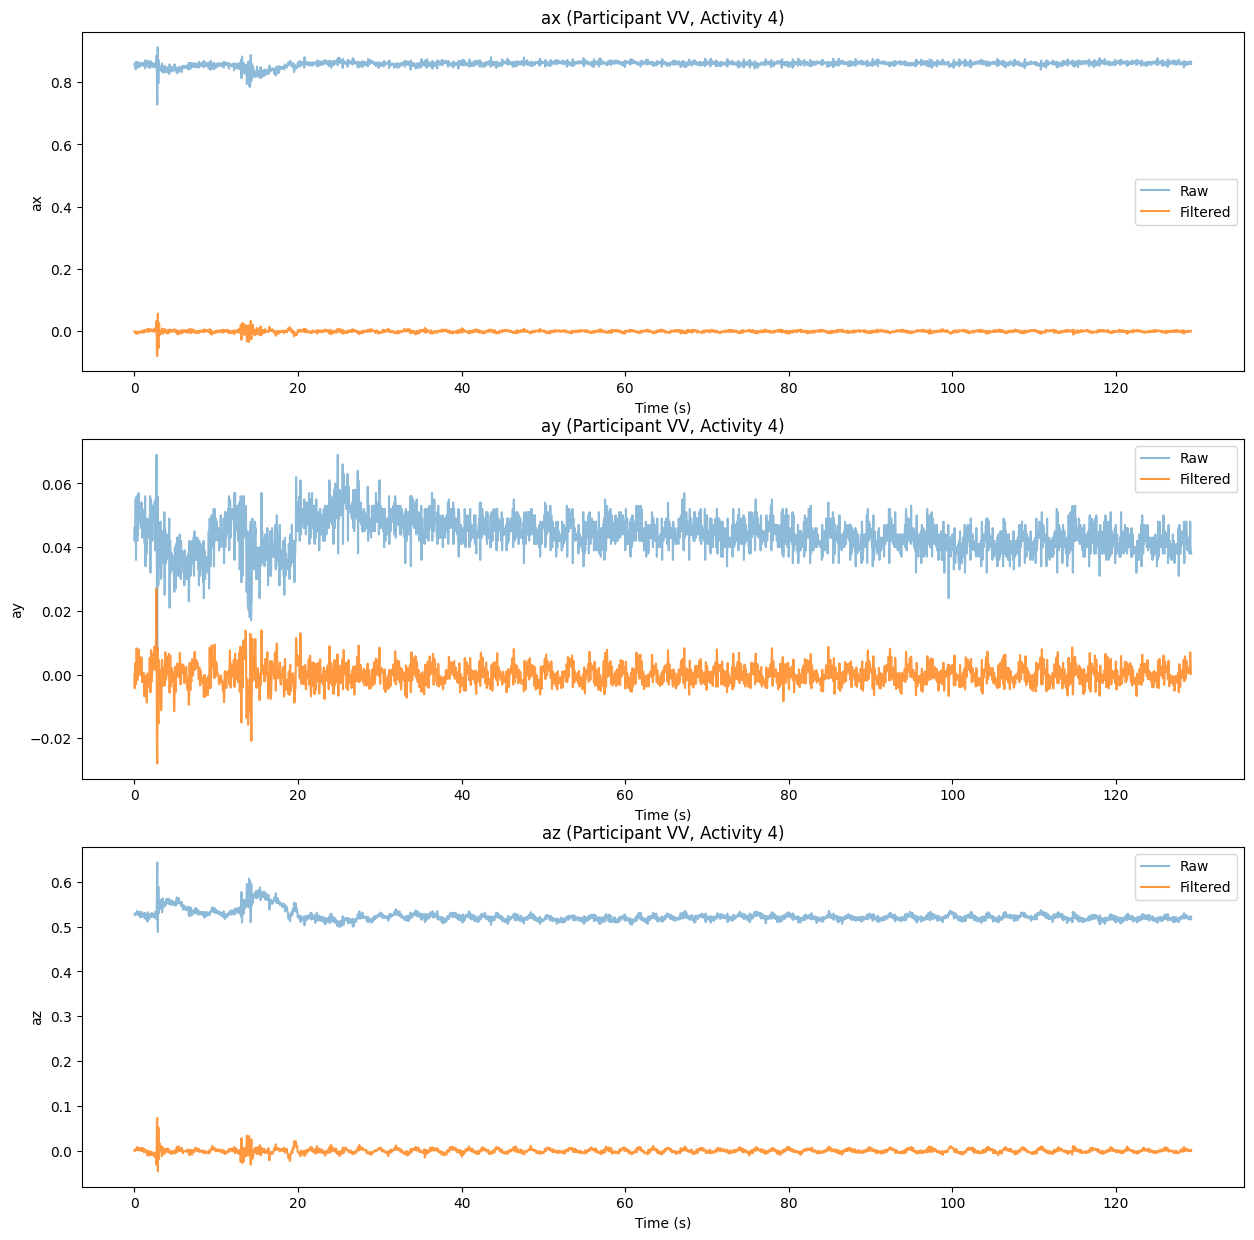

In [85]:
# Visualization of raw vs filtered data for a sample participant one activity
participant_to_plot = participant_ids[1] # 0: LL, 1: VV, 2: YL, 3: YT, 4: ZM
activity_to_plot = activity_ids[3] # 0: sitting, 1: walking, 2: running, 3: lying
original_data = df_trimmed[(df_trimmed['participant_id'] == participant_to_plot) & (df_trimmed['activity_id'] == activity_to_plot)]
filtered_data = filtered_df[(filtered_df['participant_id'] == participant_to_plot) & (filtered_df['activity_id'] == activity_to_plot)]
time = original_data['timestamp'] - original_data['timestamp'].iloc[0]
plt.figure(figsize=(15, 15))
for i, sensor_id in enumerate(sensor_ids):
    plt.subplot(len(sensor_ids), 1, i + 1)
    plt.plot(time, original_data[sensor_id], label='Raw', alpha=0.5)
    plt.plot(time, filtered_data[sensor_id], label='Filtered', alpha=0.8)
    plt.title(f'{sensor_id} (Participant {participant_to_plot}, Activity {activity_to_plot})')
    plt.xlabel('Time (s)')
    plt.ylabel(sensor_id)
    plt.legend()


# 5. Segmentation
**Use sliding windows of 1 second with overlap of 50%**

In [56]:
sampling_frequency = 25.0 # Hz
window_s = 1 # seconds
window_size = int(sampling_frequency * window_s)
overlap_s = 0.5 # seconds
overlap_size = int(sampling_frequency * overlap_s)
step_size = int(window_size - overlap_size)

In [ ]:
def segment_data(data, window_size, step_size):
    segmented_data = []
    for i in range(0, len(data) - window_size, step_size):
        segment = data.iloc[i : i + window_size]
        segmented_data.append(segment)
    return segmented_data

In [ ]:
# Segment data for each participant and activity
segmented_dfs = []

for participant_id in participant_ids:
    participant_data = filtered_df[filtered_df['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id]
        activity_data = activity_data.drop(columns=['timestamp'])
        segments = segment_data(activity_data, window_size, step_size)
        print(f"Participant {participant_id}, Activity {activity_id}: {len(segments)} segments")
        segmented_dfs.extend(segments)

print(segmented_dfs[0])

Participant LL, Activity 1: 239 segments
Participant LL, Activity 2: 231 segments
Participant LL, Activity 3: 237 segments
Participant LL, Activity 4: 229 segments
Participant VV, Activity 1: 236 segments
Participant VV, Activity 2: 235 segments
Participant VV, Activity 3: 231 segments
Participant VV, Activity 4: 248 segments
Participant YL, Activity 1: 234 segments
Participant YL, Activity 2: 234 segments
Participant YL, Activity 3: 245 segments
Participant YL, Activity 4: 244 segments
Participant YT, Activity 1: 243 segments
Participant YT, Activity 2: 237 segments
Participant YT, Activity 3: 237 segments
Participant YT, Activity 4: 237 segments
Participant ZM, Activity 1: 253 segments
Participant ZM, Activity 2: 229 segments
Participant ZM, Activity 3: 234 segments
Participant ZM, Activity 4: 238 segments
   activity_id participant_id        ax        ay        az
0            1             LL  0.002073  0.000974  0.003084
1            1             LL -0.016937 -0.003016  0.005075


# 6. Feature Extraction
**Extract Time-Domain Features from Segmented Data**

In [92]:
zero_crossing_threshold = 0.05

In [ ]:
def calculate_zero_crossings(segment_data, threshold=0.05):
    """
    Calculates the number of zero crossings in a signal segment with a given threshold.
    A zero crossing is detected when the signal crosses the threshold in either direction.
    """
    state = np.zeros(len(segment_data))
    state[segment_data > threshold] = 1
    state[segment_data < -threshold] = -1
    zero_crossings = np.diff(np.sign(state))
    return np.count_nonzero(zero_crossings)

In [ ]:
def extract_time_domain_features(segment, zero_crossing_threshold=0.05):
    """
    Extract time-domain features from a segmented signal.
    """
    features = {}
    
    # Time-domain features for each sensor axis (ax, ay, az)
    for sensor_id in sensor_ids:
        features[f'{sensor_id}_mean'] = segment[sensor_id].mean()
        features[f'{sensor_id}_std'] = segment[sensor_id].std()
        features[f'{sensor_id}_max'] = segment[sensor_id].max()
        features[f'{sensor_id}_min'] = segment[sensor_id].min()
        features[f'{sensor_id}_range'] = segment[sensor_id].max() - segment[sensor_id].min()
        features[f'{sensor_id}_skew'] = segment[sensor_id].skew()
        features[f'{sensor_id}_kurt'] = segment[sensor_id].kurtosis()
        features[f'{sensor_id}_zcr'] = calculate_zero_crossings(segment[sensor_id])

    # Cross-axis features
    features['sma'] = np.sum(np.sqrt(segment['ax']**2 + segment['ay']**2 + segment['az']**2))
    features['corr_axy'] = segment['ax'].corr(segment['ay'])
    features['corr_axz'] = segment['ax'].corr(segment['az'])
    features['corr_ayz'] = segment['ay'].corr(segment['az'])

    return features

In [ ]:
# Extract features for all segments
feature_list = []
for segment in segmented_dfs:
    features = extract_time_domain_features(segment, zero_crossing_threshold)
    features["activity_id"] = segment["activity_id"].iloc[0]
    features["participant_id"] = segment["participant_id"].iloc[0]
    feature_list.append(features)
preprocessed_dataset = pd.DataFrame(feature_list)

print("\nPre-Processed Dataset Head:")
print(preprocessed_dataset.head())
print(f"\nPre-Processed Dataset Shape: {preprocessed_dataset.shape}")


Pre-Processed Dataset Head:
    ax_mean    ax_std    ax_max    ax_min  ax_range   ax_skew   ax_kurt  \
0 -0.002901  0.004928  0.006377 -0.016937  0.023314 -0.768933  1.685408   
1  0.001048  0.008580  0.034233 -0.008386  0.042619  2.818647  9.516207   
2 -0.014103  0.041628  0.067740 -0.110841  0.178581 -0.524075  0.473809   
3 -0.004977  0.065800  0.150043 -0.110841  0.260884  0.468019 -0.174312   
4  0.014108  0.055004  0.150043 -0.096431  0.246474  0.312943  0.285617   

   ax_zcr   ay_mean    ay_std  ...  az_range   az_skew   az_kurt  az_zcr  \
0       0 -0.000697  0.002754  ...  0.019845  0.174625 -0.894858       0   
1       0 -0.001384  0.005157  ...  0.022751  0.452605 -0.518788       0   
2       6 -0.005960  0.015905  ...  0.135787 -0.499312  0.511265       4   
3      11  0.003083  0.025811  ...  0.190498 -0.018085 -0.540900       6   
4       8  0.005712  0.024911  ...  0.153899  0.274380  0.810952       3   

        sma  corr_axy  corr_axz  corr_ayz  activity_id  partici

In [ ]:
# Save the pre-processed dataset to a CSV file
preprocessed_dataset.to_csv('../../data/processed/COEN498-691_HAR_preprocessed_dataset.csv', index=False)